In [24]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

class NeuralNetworkRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_units=10, learning_rate=0.01, epochs=50, random_state=42):
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        np.random.seed(self.random_state)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def fit(self, X, y):
        input_layer_neurons = X.shape[1]
        output_neurons = 1
        
        np.random.seed(self.random_state)
        self.hidden_weights = np.random.uniform(size=(input_layer_neurons, self.hidden_units))
        self.hidden_bias = np.random.uniform(size=(1, self.hidden_units))
        self.output_weights = np.random.uniform(size=(self.hidden_units, output_neurons))
        self.output_bias = np.random.uniform(size=(1, output_neurons))
        
        for epoch in range(self.epochs):
            # Forward Propagation
            hidden_layer_activation = np.dot(X, self.hidden_weights)
            hidden_layer_activation += self.hidden_bias
            hidden_layer_output = self.sigmoid(hidden_layer_activation)
            
            output_layer_activation = np.dot(hidden_layer_output, self.output_weights)
            output_layer_activation += self.output_bias
            predicted_output = self.sigmoid(output_layer_activation)
            
            # Backpropagation
            error = y - predicted_output
            d_predicted_output = error * self.sigmoid_derivative(predicted_output)
            
            error_hidden_layer = d_predicted_output.dot(self.output_weights.T)
            d_hidden_layer = error_hidden_layer * self.sigmoid_derivative(hidden_layer_output)
            
            # Updating Weights and Biases
            self.output_weights += hidden_layer_output.T.dot(d_predicted_output) * self.learning_rate
            self.output_bias += np.sum(d_predicted_output, axis=0, keepdims=True) * self.learning_rate
            self.hidden_weights += X.T.dot(d_hidden_layer) * self.learning_rate
            self.hidden_bias += np.sum(d_hidden_layer, axis=0, keepdims=True) * self.learning_rate
        
        return self

    def predict(self, X):
        hidden_layer_activation = np.dot(X, self.hidden_weights)
        hidden_layer_activation += self.hidden_bias
        hidden_layer_output = self.sigmoid(hidden_layer_activation)
        
        output_layer_activation = np.dot(hidden_layer_output, self.output_weights)
        output_layer_activation += self.output_bias
        predicted_output = self.sigmoid(output_layer_activation)
        
        return predicted_output

# Load and shuffle the dataset
print("...............Reading the Dataset and Dataset Pre-Processing ................")
start_time = time.time()
np.random.seed(42)
dataset = shuffle(pd.read_excel("dataset_ta.xlsx"), random_state=42)

# Drop the date column
dataset = dataset.drop(columns=["Tgl/bln/thn"])

# Separate features (x) and target (y)
x = dataset.drop(columns=["curah_hujan"])
y = dataset[['curah_hujan']]

# Normalize data using Min-Max Scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)  # Normalizing the target

# Menentukan ruang parameter
param_grid = {
    'hidden_units': [10, 20],
    'learning_rate': [0.1, 0.01, 0.001],
    'epochs': [50]
}

# Fungsi untuk menjalankan GridSearchCV
def run_grid_search_cv(test_size):
    X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled.reshape(-1, 1), test_size=test_size, random_state=42)
    nn_regressor = NeuralNetworkRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=nn_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_rmse = np.sqrt(-grid_search.best_score_)
    return best_params, best_rmse

# Menjalankan GridSearchCV untuk setiap rasio pembagian data
results = {}
for test_size, ratio in zip([0.3, 0.2, 0.1], ["70:30", "80:20", "90:10"]):
    best_params, best_rmse = run_grid_search_cv(test_size)
    results[ratio] = {
        'Best RMSE': best_rmse,
        'Best Parameters': best_params
    }

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T

# Adjust the display settings for pandas DataFrame
pd.set_option('display.max_colwidth', None)

print("Neural Network Parameter Tuning Results:")
print(results_df)

...............Reading the Dataset and Dataset Pre-Processing ................
Neural Network Parameter Tuning Results:
      Best RMSE                                             Best Parameters
70:30  0.121541   {'epochs': 50, 'hidden_units': 10, 'learning_rate': 0.01}
80:20  0.118636   {'epochs': 50, 'hidden_units': 10, 'learning_rate': 0.01}
90:10  0.119005  {'epochs': 50, 'hidden_units': 10, 'learning_rate': 0.001}


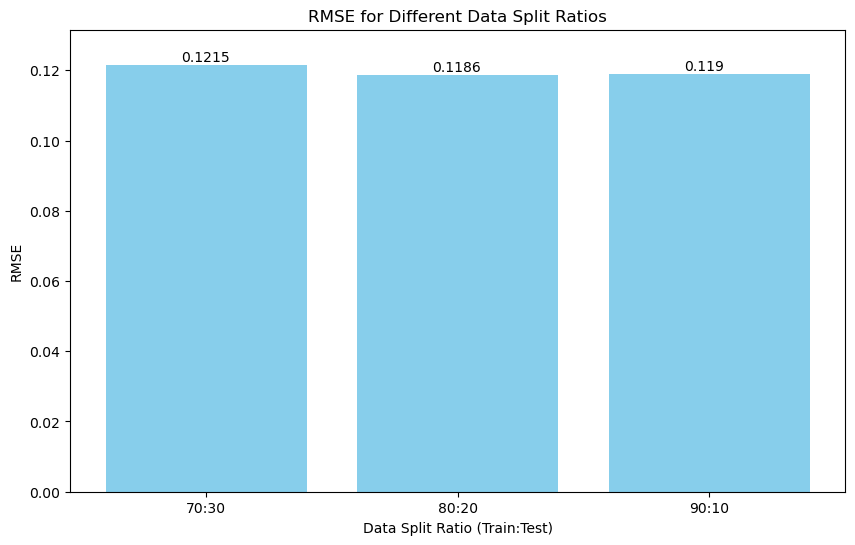

In [23]:
import matplotlib.pyplot as plt

# Data from the previous tuning results
results = {
    "70:30": {"Best RMSE": 0.121541},
    "80:20": {"Best RMSE": 0.118636},
    "90:10": {"Best RMSE": 0.119005}
}

# Extracting RMSE values and labels
ratios = list(results.keys())
rmse_values = [results[ratio]["Best RMSE"] for ratio in ratios]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(ratios, rmse_values, color='skyblue')
plt.xlabel('Data Split Ratio (Train:Test)')
plt.ylabel('RMSE')
plt.title('RMSE for Different Data Split Ratios')
plt.ylim(0, max(rmse_values) + 0.01)  # Adjust y-axis to make the chart look better

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.001, round(yval, 4))

plt.show()